In [1]:
from sys import path
from os.path import relpath, realpath, abspath, join, exists
from itertools import product

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py

pd.set_option('display.max_rows', 999)

In [2]:
from torchnetjson.builder import build_net

In [3]:
from thesis_v2 import dir_dict
from thesis_v2.data import load_data_helper
from thesis_v2.training.training_aux import load_training_results
from thesis_v2.training_extra.misc import count_params
from thesis_v2.models.maskcnn_polished.builder import load_modules

load_modules()

In [4]:
folder_to_check = 'scripts/training/yuanyuan_8k_a_3day/maskcnn_polished'
path.insert(0, join(dir_dict['root'], folder_to_check))
from submit import param_iterator_obj
from key_utils import keygen

In [5]:
# add stuff to get per neuron stats, following `basic.ipynb`.
from functools import partial

from thesis_v2.training_extra.data import generate_datasets
from thesis_v2.training_extra.evaluation import eval_fn_wrapper as eval_fn_wrapper_neural
from thesis_v2.training.training import eval_wrapper
from thesis_v2.data.prepared.yuanyuan_8k import get_data, get_neural_data

from torch.backends import cudnn
import torch
cudnn.enabled = True
cudnn.deterministic = True
cudnn.benchmark = False

_data_cache = dict()

def get_data_cached(input_size, seed):
    if (input_size, seed) not in _data_cache:
        _data_cache[input_size, seed] = get_data('a', 200, input_size,
                                                 ('042318', '043018', '051018'),
                                                 scale=0.5,
                                                 seed=seed)
    return _data_cache[input_size, seed]

def load_maskcnn_result(param, verbose):
    # this is tricky, because I did not save per neuron corr during training.
    # shit.
    #
    # afterwards, I will simply save thoese perneuron corr.
    # 
    # right now, let's load the data set and do the evaluation again.
    assert param['out_channel'] == 16
    assert param['num_layer'] == 2
    assert param['kernel_size_l1'] == 9
    assert param['pooling_ksize'] == 3
    assert param['pooling_type'] == 'avg'

    assert param['model_seed'] == 0

    key = keygen(**{k: v for k, v in param.items() if k not in {'scale', 'smoothness'}})
    result = load_training_results(key, return_model=False)
        # load twice, first time to get the model.
    result = load_training_results(key, return_model=True, model=build_net(result['config_extra']['model']))
    
    # then create data set.
#     datasets = get_data('a', 200, param['input_size'], ('042318', '043018', '051018'), scale=0.5,
#                         seed=param['split_seed'])
    datasets = get_data_cached(param['input_size'], param['split_seed'])

    
    datasets = {
        'X_train': datasets[0].astype(np.float32),
        'y_train': datasets[1],
        'X_val': datasets[2].astype(np.float32),
        'y_val': datasets[3],
        'X_test': datasets[4].astype(np.float32),
        'y_test': datasets[5],
    }
    
    # only the test one is needed.
    datasets = generate_datasets(
        **datasets,
        per_epoch_train=True, shuffle_train=True,
    )['test']
    
    result_on_the_go = eval_wrapper(result['model'].cuda(),
                                    datasets,
                                    'cuda',
                                    1,
                                    partial(eval_fn_wrapper_neural, loss_type=param['loss_type']),
                                        lambda dummy1,dummy2,dummy3: torch.tensor(0.0)
                                   )
    ret = np.asarray(result_on_the_go['corr'])
    if verbose:
        print(result_on_the_go['corr_mean'], result['stats_best']['stats']['test']['corr_mean'],
             ret.mean())
    assert ret.shape == (79,)
    return ret

In [6]:
# # compute cc_max
from strflab.stats import cc_max
from thesis_v2.data.prepared.yuanyuan_8k import get_neural_data_per_trial

cc_max_all_neurons = cc_max(get_neural_data_per_trial(
    ('042318', '043018','051018',))
                           )
assert cc_max_all_neurons.shape == (79,)
assert np.all(cc_max_all_neurons > 0)

In [7]:
def load_everything():
    _df_collect = []
    for idx, param in enumerate(param_iterator_obj.generate()):
        if idx % 50 == 0:
            print(idx)
            verbose=True
        else:
            verbose=False
        
        assert len(param) == 16
#         assert param['split_seed'] == 'legacy'
        assert param['out_channel'] == 16
        assert param['num_layer'] == 2
        assert param['kernel_size_l1'] == 9
        assert param['pooling_ksize'] == 3
        assert param['pooling_type'] == 'avg'
        
        assert param['model_seed'] == 0
        
        key = keygen(**{k: v for k, v in param.items() if k not in {'scale', 'smoothness'}})
        # 10 to go.
        result = load_training_results(key, return_model=False)
        # load twice, first time to get the model.
        result = load_training_results(key, return_model=True, model=build_net(result['config_extra']['model']))
        num_epochs = [len(x) for x in result['stats_all']]
        
        
        corr_each = load_maskcnn_result(param, verbose)
        
        assert cc_max_all_neurons.shape == corr_each.shape == (79,)
        
        _df_collect.append(
            {
                'split_seed': str(param['split_seed']),
                
                
                'act_fn': param['act_fn'],
                'bn_before_act': param['bn_before_act'],
                'bn_after_fc': param['bn_after_fc'],
                'input_size': param['input_size'],
                'loss_type': param['loss_type'],
                
                # 5 to go
                
                'scale': float(param['scale']),
                # 
                'smoothness': float(param['smoothness']),
                # 
                
                # 1 to go
                
                
#                 'model_seed': param['model_seed'],
                'corr_test': result['stats_best']['stats']['test']['corr_mean'],
                'corr2_normed_test': ((corr_each/cc_max_all_neurons)**2).mean(),
#                 'max_epoch': max(num_epochs),
#                 'num_param': count_params(result['model']),
            }
        )
        _df =  pd.DataFrame(_df_collect, columns=['split_seed', 'act_fn', 'bn_before_act', 'bn_after_fc',
                                                  'input_size', 'loss_type', 'scale',
                                                  'smoothness',
#                                                   'model_seed',
                                                  'corr_test',
#                                                   'num_param',
#                                                   'max_epoch',
                                                  'corr2_normed_test',
                                                 ])
        _df = _df.set_index(['split_seed', 'act_fn', 'bn_before_act', 'bn_after_fc',
                             'input_size', 'loss_type', 'scale',
                             'smoothness',
#                              'model_seed',
                            ],verify_integrity=True)
    return _df

In [8]:
# collect all data.
# it's a series.
df_all = load_everything()

df_dict = {
    'legacy': df_all['corr_test'],
    'corr2_normed': df_all['corr2_normed_test'],
}

0
0.5170159339904785 0.5170159339904785 0.5170158989067319
50
0.4919770061969757 0.4919770061969757 0.49197696356833737
100
0.4947616457939148 0.4947616457939148 0.49476166182680975
150
0.42052823305130005 0.42052823305130005 0.42052819553314696
200
0.4970192313194275 0.4970191717147827 0.4970191933120353
250
0.4713904238954375 0.47139042502717127 0.4713904238954375
300
0.49351322650909424 0.49351322650909424 0.49351313059465796
350
0.44084542989730835 0.44084542989730835 0.4408453859188417
400
0.48460841178894043 0.4846084713935852 0.48460844654259805
450
0.3916296362876892 0.3916296064853668 0.3916296018641206
500
0.47796809673309326 0.47796809673309326 0.4779680401464052
550
0.44768890738487244 0.44768890738487244 0.4476889119353853
600
0.5177845358848572 0.5177845358848572 0.517784570402737
650
0.4905356764793396 0.4905356764793396 0.4905357035466387
700
0.500257134437561 0.5002570748329163 0.5002570354580125
750
0.44820886850357056 0.44820886850357056 0.4482088244366872
800
0.5152

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

from thesis_v2.plots.basic import scatter
from thesis_v2.plots.util import savefig

In [10]:
def plot_scatter(df_this, key1, key2, level, xlabel, ylabel, key):
    plt.close('all')
    fig, ax = plt.subplots(figsize=(3,3))
    
    x = df_this.xs(key1, level=level).sort_index().values
    y = df_this.xs(key2, level=level).sort_index().values
    
    scatter(ax, x, y, xlabel, ylabel, xlim=(0.0, 0.6), ylim=(0.0,0.6))
    # TODO set tick labels.
    ax.text(0.05, 0.95, f'N={x.size}',
            horizontalalignment='left',
            verticalalignment='top', transform=ax.transAxes)
    
    # adjust figure size to make sure the aspect ratio is correct.
    fig.subplots_adjust(left=0.2,bottom=0.2,right=0.9,top=0.9)
    
    # save fig.
    savefig(fig, f'yuanyuan_8k_a_3day/maskcnn_polished/hyperparameter_no_size_change/{key}.pdf')
    
    plt.show()

In [11]:
# df_to_use = df_to_use.xs('relu', level='act_fn')
# if you uncomment this and replot, you can see all those outliers disappear.
# remember to comment out `plot_scatter(df_to_use, 'softplus', 'relu', 'act_fn', 'softplus', 'relu', 'act')`, as act_fn column disappears then.

In [12]:
def gen_all_plots_for_a_df(df_this, key_prefix=''):
    # comments apply to original, raw average cc metrics. they should apply to normed_cc2 as well.
    
    plot_scatter(df_this, 50, 100, 'input_size', '50', '100', key_prefix+'input_size')
    plot_scatter(df_this, 'softplus', 'relu', 'act_fn', 'softplus', 'relu', key_prefix+'act')
    
    
    
    
    plot_scatter(df_this, True, False, 'bn_before_act', 'BN before activation', 'BN after activation', key_prefix+'bn_before_act')
    # pick BN before activation, ignore those outliers.

    # outliers are all due to softplus. check line `df_to_use = df_to_use.xs('relu', level='act_fn')`.
    
    
    plot_scatter(df_this, True, False, 'bn_after_fc', 'FC with BN', 'FC withnot BN',key_prefix+ 'bn_after_fc')
    # pick FC without BN, ignore those outliers.

    # outliers are all due to softplus. check line `df_to_use = df_to_use.xs('relu', level='act_fn')`.
    
    
    
    
    
    
    # scale
    # no need to be shown in the paper.
    plot_scatter(df_this, 0.01, 0.1, 'scale', '0.01', '0.1', key_prefix+'scale_0p1_vs_0p01')  # similar.
    plot_scatter(df_this, 0.001, 0.01, 'scale', '0.001', '0.01', key_prefix+'scale_0p01_vs_0p001')  # 0.01 is better.
    
    
    
    
    # smoothness has been examined before. no need to show everything. here I just show an example.
    plot_scatter(df_this, 0.000005, 0.005, 'smoothness', '0.000005', '0.005', key_prefix+'smooth_0p005_vs_0p000005')  # 0.01 is better.
    plot_scatter(df_this, 0.000005, 0.00005, 'smoothness', '0.000005', '0.00005', key_prefix+'smooth_0p00005_vs_0p000005')  # 0.01 is better.

    
    
    # loss_type
    plot_scatter(df_this, 'poisson', 'mse', 'loss_type', 'poisson', 'mse', key_prefix+'loss_type')


    # outliers (those with ~0 performance points) are all due to softplus. check line `df_to_use = df_to_use.xs('relu', level='act_fn')`.

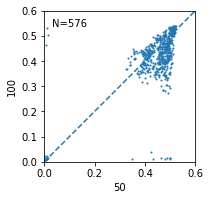

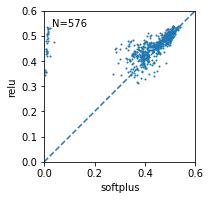

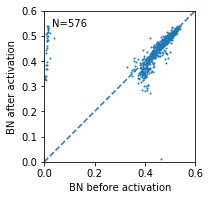

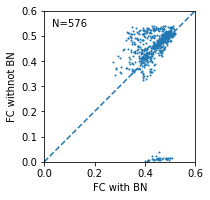

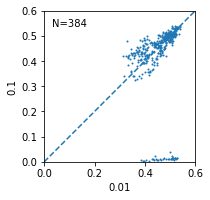

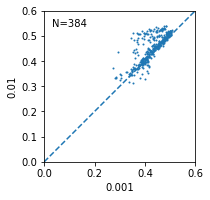

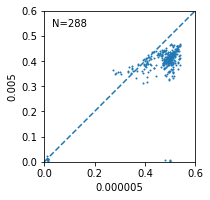

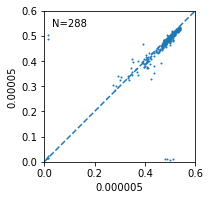

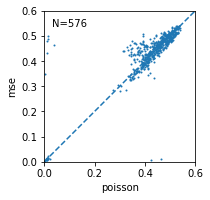

In [13]:
gen_all_plots_for_a_df(df_dict['legacy'])

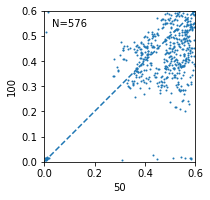

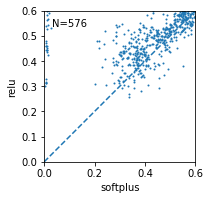

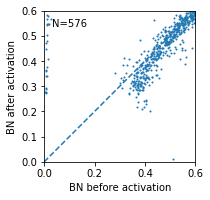

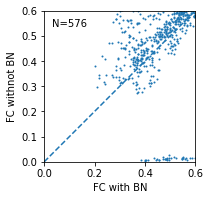

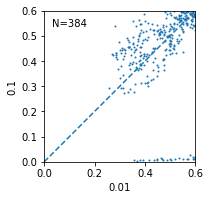

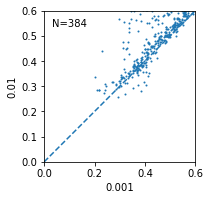

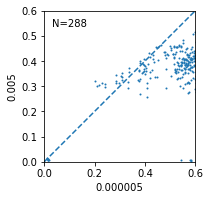

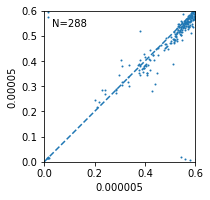

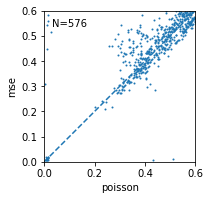

In [14]:
gen_all_plots_for_a_df(df_dict['corr2_normed'], 'corr2normed_')